**MSc Computational Physics AUTH**<br>
**Computational Tools**<br>
**Academic Year: 2023-2024**<br>
**Semester 1**<br>
**Implemented by: Ioannis Stergakis**<br>
**AEM: 4439**<br>

# **SET #2:** ***Estimating π using Monte Carlo simulation***
**Notebook 1**<br> 

**Contents:**<br>
*->1. Parallel programming implementation: compiling and running OpenMP C scripts*<br>
*for fixed number of total points and different number of threads*<br>
*->2. Execution time analysis codes*<br>
*->3. Parallel speedup analysis codes*<br>
*->4. Results*<br>

**Importing useful libraries**<br>

Before we begin our code implementation we import the necessary Python libraries.

In [70]:
import numpy as np 
import sympy as smp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd  
import time 
import subprocess
import re
import os 

## *1. OpenMP C scripts compilation and execution using the Python 'subprocess' module*

### **1.1 Defining a function to implement the compilation and execution of C scripts**

In [71]:
# Inputs

# num_threads: list of (different) numbers of threads to be used
# points: total number of random points to be generated at every Monte Carlo simulation 

def pi_estimation_parallel_1(num_threads,points):
    # Initializing storage lists
    pi_est_vals = [] # list to store the pi estimations
    exe_times_C =[] # list to store the execution time (as measured in the C .exe file)
    exe_times_Py = [] # list to store the execution time (as measured in the Jupyter notebook)

    # C Script compilation

    # For Windows compilation use: ['gcc','pi_estimation_MC.c','-o','pi_estimation_MC','-fopenmp']
    # For Linux compilation use: ['g++','pi_estimation_MC.c','-o','pi_estimation_MC.exe','-fopenmp']
    # as the first argument in the subprocess.run() function
    compile_procedure = subprocess.run(['gcc', 'pi_estimation_MC.c', '-o', 'pi_estimation_MC', '-fopenmp'], capture_output=True, text=True, shell=True)
    
    
    # Checking for correct compilation
    if compile_procedure.returncode == 0: # successful compilation
        print(">Successful compilation!\n")
        print(">Running the .exe file!\n")
        
        # Initializing simulation counter index
        i = 1

        # Running the C executable for different number of threads
        for threads in num_threads:
            # Printing the queue number of the current
            print("\n\n>MONTE CARLO SIMULATION %d running....."%i)

            # Setting time meausurement (in the notebook) and running the compiled C executable using the current threads

            # For Windows execution use: ['pi_estimation_MC',f'{points}',f'{threads}']
            # For Linux execution use: ['./pi_estimation_MC',f'{points}',f'{threads}']
            # as the first argument in the subprocess.run() function
            start_time = time.time() # starting the execution time measurement 
            exe_procedure = subprocess.run(['pi_estimation_MC', f'{points}', f'{threads}'], capture_output=True, text=True, shell=True)
            end_time = time.time() # ending the execution time measurements

            # Obtain the output from the current execution
            exe_output = exe_procedure.stdout

            # Print the output of the current execution
            print(exe_output)

            # Print any error messages in the execution, if such are present
            if exe_procedure.stderr:
                print(">Error messages:\n", exe_procedure.stderr)

            # Using regular expression to exctract the pi estimation from the output
            pi_estimation_str = re.findall(r"Pi Estimation: (\d.+)", exe_output)
            pi_estimation_list = [float(pi_estimation) for pi_estimation in pi_estimation_str] # Convert the extracted string to float list
            pi_estimation = pi_estimation_list[0] # Obtain the value from the float list

            # Using regular expression to exctract the C measured execution time from the output
            cpu_time_C_str = re.findall(r"Execution Time: (\d.+) seconds", exe_output)
            cpu_time_C_list = [float(cpu_time_C) for cpu_time_C in cpu_time_C_str] # Convert the extracted string to float list
            cpu_time_C = cpu_time_C_list[0] # Obtain the value from the float list

            # Calculate the execution time measured in the Jupyter notebook
            cpu_time_Py =  end_time - start_time

            # Print the Jupyter measured info of the current simulation
            print(">>MC SIMULATION INFO (Jupyter notebook)")
            print("--------------------------------------")
            print("Execution time: %.10f seconds"%cpu_time_Py)
            print("--------------------------------------")

            # Appending values to the respective storage lists
            pi_est_vals.append(pi_estimation) 
            exe_times_C.append(cpu_time_C)
            exe_times_Py.append(cpu_time_Py)

            # Increasing the count of the simulations by 1
            i = i + 1
    
    else: # failed compilation
        print(">Compilation failed:\n")
        print(compile_procedure.stderr)
            

    return [pi_est_vals,exe_times_C,exe_times_Py]

### **1.2 Defining a function to insert data from a recorded Monte Carlo simulation session**

In [72]:
# Inputs

# filename: the name of the .csv file to be opened (for example "MC_Sim1_exh.csv")
# header_include: can either take the value 'None' when headers are not included in the .csv matrix
# or can take the value of an integer number  

def pi_estimation_insert(filename,header_include):
    read_data = pd.read_csv(filename,header=header_include)
    return read_data

## *2. Execution time analysis*

### **2.1 Definition of analysis and plotting function for the execution time (compare C vs Python measured times)**

In [73]:
# Inputs

# num_threads: list of (different) numbers of threads used
# exe_times_C: list of the exexcution times, C measured
# exe_times_Py: list of the execution times, Python measured

def exe_time_analysis_1(num_threads,exe_times_C,exe_times_Py):
    print(">Execution time analysis:")

    # Calculating the average difference between C and Python measured execution times
    n = len(exe_times_C)
    C_Py_diff = [] # storage list of the difference Py_time - C_time values
    for i in range(0,n):
        C_Py_diff.append(exe_times_Py[i]-exe_times_C[i])
    C_Py_diff_avg = np.average(C_Py_diff)

    # Printing the average difference result
    print('--------------------------------') 
    print("Average difference in Python and C execution times: %.4e"%C_Py_diff_avg)
    print('--------------------------------')  
    

    # Plotting the execution time versus the number of threads
    plt.plot(num_threads,exe_times_C,'--o',lw=1.3,label='C measured E.T.')
    plt.plot(num_threads,exe_times_Py,'--o',lw=1.3,label='Python measured E.T')
    plt.grid()

### **2.2 Definition of analysis and plotting function for the execution time (compare Exhaust vs Separate measured times)**

In [74]:
# Inputs

# num_threads: list of (different) numbers of threads used
# exe_times_C_exh: list of the exexcution times of an Exhaust session, C measured
# exe_times_C_sep: list of the exexcution times of a Separate session, C measured
# exe_times_Py_exh: list of the execution times of an Exhaust session, Python measured
# exe_times_Py_sep: list of the execution times of a Session session, Python measured

def exe_time_analysis_2(num_threads,exe_times_C_exh,exe_times_C_sep,exe_times_Py_exh,exe_times_Py_sep):
    print(">Execution time analysis:")

    # Calculating the average difference between Exhaust and Seperate measured execution times (C and Python)
    n = len(num_threads)
    C_exh_sep_diff = [] # storage list of the difference C_time_exh - C_time_sep values
    Py_exh_sep_diff = [] # storage list of the difference Py_time_exh - Py_time_sep values
    for i in range(0,n):
        C_exh_sep_diff.append(exe_times_C_exh[i]-exe_times_C_sep[i])
        Py_exh_sep_diff.append(exe_times_Py_exh[i]-exe_times_Py_sep[i])
    C_exh_sep_avg = np.average(C_exh_sep_diff)
    Py_exh_sep_avg = np.average(Py_exh_sep_diff)

    # Printing the average differences results
    print('--------------------------------')
    print("Average difference in Exhaust vs Seperate execution times (C): %.4e"%C_exh_sep_avg)
    print("Average difference in Exhaust vs Seperate execution times (Python): %.4e"%C_exh_sep_avg)
    print('--------------------------------')
    

    # Plotting the execution time versus the number of threads
    plt.plot(num_threads,exe_times_C_exh,'--o',lw=1.3,label='C measured E.T. (exh.)')
    plt.plot(num_threads,exe_times_C_sep,'--o',lw=1.3,label='C measured E.T (sep.)')
    plt.plot(num_threads,exe_times_Py_exh,'--o',lw=1.3,label='Py measured E.T. (exh.)')
    plt.plot(num_threads,exe_times_Py_sep,'--o',lw=1.3,label='Py measured E.T (sep.)')
    plt.grid()

## *3. Parallel Speedup analysis*

### **3.1 Definition of plotting and fitting function for the parallel speedup (compare C and Python measured speedups)**

In [75]:
# Inputs

# num_threads: list of (different) numbers of threads used
# exe_times_C: list of the exexcution times, C measured
# exe_times_Py: list of the execution times, Python measured

def par_speed_analysis_1(num_threads,exe_times_C,exe_times_Py):
    print(">Parallel speedup analysis:")
    
    # Calculating the length of num_threads list
    n = len(num_threads)
        
    # Calculating the parallel speedup
    par_speedup_C = []
    par_speedup_Py = []
    for i in range(0,n):
        par_speedup_C.append(exe_times_C[0]/exe_times_C[i])
        par_speedup_Py.append(exe_times_Py[0]/exe_times_Py[i])
            
    # Defining the Amdahl's law as a function
    def amdahl_law(s,p):
        return 1 / ((1 - p) + p / s)
        
    # Fitting the simulations data by applying Amdahl's law
    param_fit_C, param_cov_C = curve_fit(amdahl_law, num_threads, par_speedup_C)
    param_fit_Py, param_cov_Py = curve_fit(amdahl_law, num_threads, par_speedup_Py)

    # Presenting the fitting results
    print('\nFITTING RESULTS FOR THE PARALLEL SPEEDUP\n')
    
    print('C measured Speedup analysis:')
    print('--------------------------------')
    p_C = param_fit_C[0]
    print('Amdahl\'s law fit p: %.3f'%p_C)
    print('Parallel portion: %.3f %%'%(p_C*100))
    print('Maximum possible speedup at 10000 cores is S_latency(10000): %f'%amdahl_law(10**4,p_C))
    print('--------------------------------\n')

    print('Python measured Speedup analysis:')
    print('--------------------------------')
    p_Py = param_fit_Py[0]
    print('Amdahl\'s law fit p: %.3f'%p_Py)
    print('Parallel portion: %.3f %%'%(p_Py*100))
    print('Maximum possible speedup at 10000 cores is S_latency(10000): %f'%amdahl_law(10**4,p_Py))
    print('--------------------------------\n')

    # Plotting the parallel speedup versus the number of threads
    plt.plot(num_threads,par_speedup_C,'o',ms=5,label='Speedup I (C measured)')
    plt.plot(num_threads,par_speedup_Py,'o',ms=5,label='Speedup II (Python measured)')

    # Plot the fitted curves

    # Number of threads for the fitting curves
    num_threads_fit = np.linspace(num_threads[0], num_threads[n-1], 100)

    # Fitting curve for the C measured parralel speedup 
    speedup_fit_C = amdahl_law(num_threads_fit, param_fit_C)
    plt.plot(num_threads_fit, speedup_fit_C,lw=1.5,label='Amdahl\'s Law Fit Ι (%.1f%%)'%(p_C*100))

    # Fitting curve for the Python measured parralel speedup 
    speedup_fit_Py = amdahl_law(num_threads_fit, param_fit_Py)
    plt.plot(num_threads_fit, speedup_fit_Py,lw=1.5,label='Amdahl\'s Law Fit ΙΙ (%.1f%%)'%(p_Py*100))

    plt.grid()

### **3.2 Definition of plotting and fitting function for the parallel speedup (compare Exhaust vs Separate speedups)**

In [76]:
# Inputs

# num_threads: list of (different) numbers of threads used
# exe_times_C_exh: list of the exexcution times of an Exhaust session, C measured
# exe_times_C_sep: list of the exexcution times of a Separate session, C measured
# exe_times_Py_exh: list of the execution times of an Exhaust session, Python measured
# exe_times_Py_sep: list of the execution times of a Session session, Python measured

def par_speed_analysis_2(num_threads,exe_times_C_exh,exe_times_C_sep,exe_times_Py_exh,exe_times_Py_sep):
    print(">Parallel speedup analysis:")

    # Calculating the length of num_threads list
    n = len(num_threads)
        
    # Calculating the parallel speedup
    par_speedup_C_exh = []
    par_speedup_C_sep = []
    par_speedup_Py_exh = []
    par_speedup_Py_sep = []
    for i in range(0,n):
        par_speedup_C_exh.append(exe_times_C_exh[0]/exe_times_C_exh[i])
        par_speedup_C_sep.append(exe_times_C_sep[0]/exe_times_C_sep[i])
        par_speedup_Py_exh.append(exe_times_Py_exh[0]/exe_times_Py_exh[i])
        par_speedup_Py_sep.append(exe_times_Py_sep[0]/exe_times_Py_sep[i])
            
    # Defining the Amdahl's law as a function
    def amdahl_law(s,p):
        return 1 / ((1 - p) + p / s)
        
    # Fitting the simulations data by applying Amdahl's law
    param_fit_C_exh, param_cov_C_exh = curve_fit(amdahl_law, num_threads, par_speedup_C_exh)
    param_fit_C_sep, param_cov_C_sep = curve_fit(amdahl_law, num_threads, par_speedup_C_sep)
    param_fit_Py_exh, param_cov_Py_exh = curve_fit(amdahl_law, num_threads, par_speedup_Py_exh)
    param_fit_Py_sep, param_cov_Py_sep = curve_fit(amdahl_law, num_threads, par_speedup_Py_sep)

    # Presenting the fitting results
    print('\nFITTING RESULTS FOR THE PARALLEL SPEEDUP\n')
    
    print('C measured Speedup analysis (Exhaust Session):')
    print('--------------------------------')
    p_C_exh = param_fit_C_exh[0]
    print('Amdahl\'s law fit p: %.3f'%p_C_exh)
    print('Parallel portion: %.3f %%'%(p_C_exh*100))
    print('Maximum possible speedup at 10000 cores is S_latency(10000): %f'%amdahl_law(10**4,p_C_exh))
    print('--------------------------------\n')

    print('C measured Speedup analysis (Seperate Session):')
    print('--------------------------------')
    p_C_sep= param_fit_C_sep[0]
    print('Amdahl\'s law fit p: %.3f'%p_C_sep)
    print('Parallel portion: %.3f %%'%(p_C_sep*100))
    print('Maximum possible speedup at 10000 cores is S_latency(10000): %f'%amdahl_law(10**4,p_C_sep))
    print('--------------------------------\n')

    print('Python measured Speedup analysis (Exhaust Session):')
    print('--------------------------------')
    p_Py_exh = param_fit_Py_exh[0]
    print('Amdahl\'s law fit p: %.3f'%p_Py_exh)
    print('Parallel portion: %.3f %%'%(p_Py_exh*100))
    print('Maximum possible speedup at 10000 cores is S_latency(10000): %f'%amdahl_law(10**4,p_Py_exh))
    print('--------------------------------\n')

    print('Python measured Speedup analysis (Seperate Session):')
    print('--------------------------------')
    p_Py_sep = param_fit_Py_sep[0]
    print('Amdahl\'s law fit p: %.3f'%p_Py_sep)
    print('Parallel portion: %.3f %%'%(p_Py_sep*100))
    print('Maximum possible speedup at 10000 cores is S_latency(10000): %f'%amdahl_law(10**4,p_Py_sep))
    print('--------------------------------\n')

    # Plotting the parallel speedup versus the number of threads
    plt.plot(num_threads,par_speedup_C_exh,'o',ms=5,label='Exh. Speedup I (C measured)')
    plt.plot(num_threads,par_speedup_C_sep,'o',ms=5,label='Sep. Speedup I (C measured)')
    plt.plot(num_threads,par_speedup_Py_exh,'o',ms=5,label='Exh. Speedup II (Python measured)')
    plt.plot(num_threads,par_speedup_Py_sep,'o',ms=5,label='Sep. Speedup II (Python measured)')

    # Plot the fitted curves

    # Number of threads for the fitting curves
    num_threads_fit = np.linspace(num_threads[0], num_threads[n-1], 100)

    # Fitting curve for the C measured parralel speedup (Exhaust Session)
    speedup_fit_C_exh = amdahl_law(num_threads_fit, param_fit_C_exh)
    plt.plot(num_threads_fit, speedup_fit_C_exh,lw=1.5,label='Amdahl\'s Law Fit Exh. Ι (%.1f%%)'%(p_C_exh*100))

    # Fitting curve for the C measured parralel speedup (Seperate Session)
    speedup_fit_C_sep = amdahl_law(num_threads_fit, param_fit_C_sep)
    plt.plot(num_threads_fit, speedup_fit_C_sep,lw=1.5,label='Amdahl\'s Law Fit Sep. Ι (%.1f%%)'%(p_C_sep*100))

    # Fitting curve for the Python measured parralel speedup (Exhaust Session)
    speedup_fit_Py_exh = amdahl_law(num_threads_fit, param_fit_Py_exh)
    plt.plot(num_threads_fit, speedup_fit_Py_exh,lw=1.5,label='Amdahl\'s Law Fit Exh. ΙΙ (%.1f%%)'%(p_Py_exh*100))

    # Fitting curve for the Python measured parralel speedup (Seperate Session)
    speedup_fit_Py_sep = amdahl_law(num_threads_fit, param_fit_Py_sep)
    plt.plot(num_threads_fit, speedup_fit_Py_sep,lw=1.5,label='Amdahl\'s Law Fit Sep. ΙΙ (%.1f%%)'%(p_Py_sep*100))

    plt.grid()

## *4. Results*

### **4.1 Presenting the execution time and parallel speedup results from recorded Monte Carlo simulation session**

#### 4.1.1 Exhaust Session Results

EXHAUST SESSION RESULTS



,Threads,Max Threads,Total Points,Pi Estimation,Error (%),Exe Time (C) [sec],Exe Time (Py) [sec]
0,1,22,1.000000e+10,3.141398,0.006195,332.374,332.534587
1,2,22,1.000000e+10,3.141397,0.006213,138.610,138.679229
2,4,22,1.000000e+10,3.141388,0.006513,74.877,74.932970
3,8,22,1.000000e+10,3.141370,0.007075,64.556,64.607328
4,16,22,1.000000e+10,3.141347,0.007821,52.343,52.399650
5,32,22,1.000000e+10,3.141332,0.008296,54.856,54.911387
6,64,22,1.000000e+10,3.141102,0.015604,57.411,57.464941


>Execution time analysis:
--------------------------------
Average difference in Python and C execution times: 7.1870e-02
--------------------------------


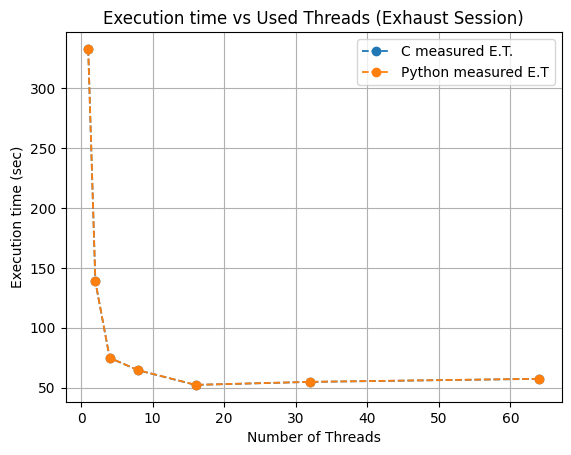

>Parallel speedup analysis:

FITTING RESULTS FOR THE PARALLEL SPEEDUP

C measured Speedup analysis:
--------------------------------
Amdahl's law fit p: 0.867
Parallel portion: 86.663 %
Maximum possible speedup at 10000 cores is S_latency(10000): 7.493219
--------------------------------

Python measured Speedup analysis:
--------------------------------
Amdahl's law fit p: 0.867
Parallel portion: 86.655 %
Maximum possible speedup at 10000 cores is S_latency(10000): 7.488809
--------------------------------



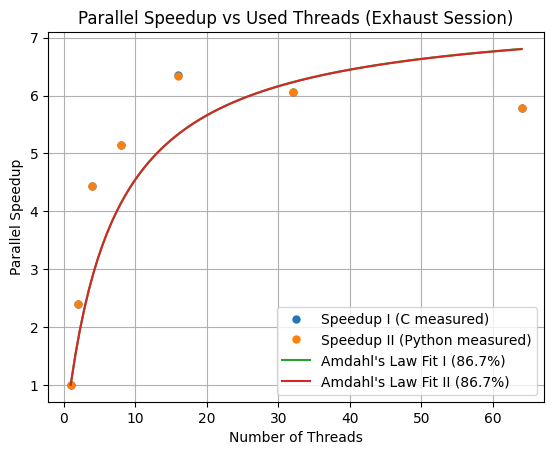

In [77]:
print("EXHAUST SESSION RESULTS\n")

# Inserting and showing the data from the "MC_Sim1_exhaust.csv" file
MC_exhaust_data = pi_estimation_insert("MC_Sim1_exhaust.csv",0)
display(MC_exhaust_data)

# Execution time analysis

# Getting the number of threads used in the exhaust session
MC_exhaust_num_threads_data = MC_exhaust_data.iloc[:,0]
n = len(MC_exhaust_num_threads_data)
MC_exhaust_num_threads = [] # storage list for the number of threads

# Getting the execution times (C measured) from the exhaust session
MC_exhaust_times_C_data = MC_exhaust_data.iloc[:,5]
MC_exhaust_times_C = [] # storage list for the execution times (C measured)

# Getting the execution times (Python measured) from the exhaust session
MC_exhaust_times_Py_data = MC_exhaust_data.iloc[:,6]
MC_exhaust_times_Py = [] # storage list for the execution times (Python measured)

# Appending the collected data to the respective storage lists (to ensure we get only the values)
for i in range(0,n):
    MC_exhaust_num_threads.append(MC_exhaust_num_threads_data[i])
    MC_exhaust_times_C.append(MC_exhaust_times_C_data[i])
    MC_exhaust_times_Py.append(MC_exhaust_times_Py_data[i])

# Presenting the execution difference results and the execution plot
exe_time_analysis_1(MC_exhaust_num_threads,MC_exhaust_times_C,MC_exhaust_times_Py)

# Adding labels, title and legend for clarity
plt.xlabel("Number of Threads")
plt.ylabel("Execution time (sec)")
plt.title("Execution time vs Used Threads (Exhaust Session)")
plt.legend()
plt.show()

# Parallel speedup analysis

# Presenting the speedup results and the speedup plot
par_speed_analysis_1(MC_exhaust_num_threads,MC_exhaust_times_C,MC_exhaust_times_Py)

# Adding labels, title and legend for clarity
plt.xlabel("Number of Threads")
plt.ylabel("Parallel Speedup")
plt.title("Parallel Speedup vs Used Threads (Exhaust Session)")
plt.legend()
plt.show()

#### 4.1.2 Seperate Session Results

SEPERATE SESSION RESULTS



,Threads,Max Threads,Total Points,Pi Estimation,Error (%),Exe Time (C) [sec],Exe Time (Py) [sec]
0,1,22,1.000000e+10,3.141398,0.006210,309.671,309.806748
1,2,22,1.000000e+10,3.141398,0.006193,126.734,127.001175
2,4,22,1.000000e+10,3.141384,0.006646,73.559,73.774159
3,8,22,1.000000e+10,3.141369,0.007134,47.059,47.233396
4,16,22,1.000000e+10,3.141349,0.007762,42.289,42.391263
5,32,22,1.000000e+10,3.141326,0.008493,39.385,39.621967
6,64,22,1.000000e+10,3.141100,0.015676,37.555,37.669876


>Execution time analysis:
--------------------------------
Average difference in Python and C execution times: 1.7808e-01
--------------------------------


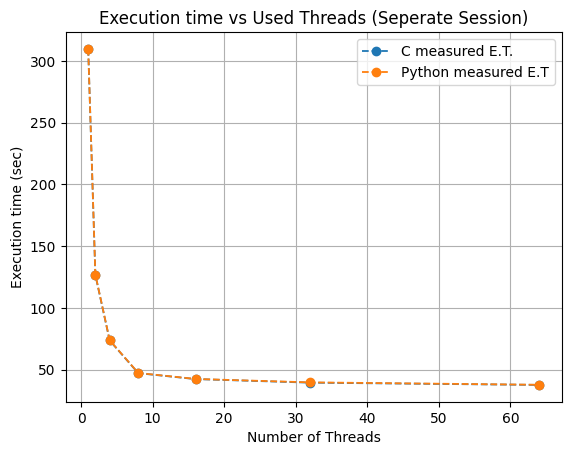

>Parallel speedup analysis:

FITTING RESULTS FOR THE PARALLEL SPEEDUP

C measured Speedup analysis:
--------------------------------
Amdahl's law fit p: 0.904
Parallel portion: 90.373 %
Maximum possible speedup at 10000 cores is S_latency(10000): 10.377693
--------------------------------

Python measured Speedup analysis:
--------------------------------
Amdahl's law fit p: 0.903
Parallel portion: 90.330 %
Maximum possible speedup at 10000 cores is S_latency(10000): 10.332093
--------------------------------



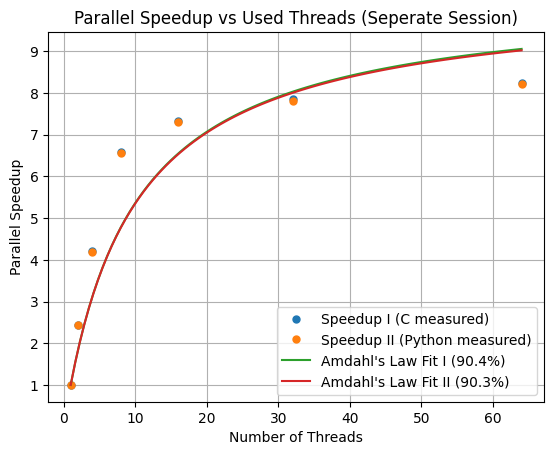

In [78]:
print("SEPERATE SESSION RESULTS\n")

# Inserting and showing the data from the "MC_Sim1_exhaust.csv" file
MC_sep_data = pi_estimation_insert("MC_Sim1_sep.csv",0)
display(MC_sep_data)

# Execution time analysis

# Getting the number of threads used in the exhaust session
MC_sep_num_threads_data = MC_sep_data.iloc[:,0]
n = len(MC_sep_num_threads_data)
MC_sep_num_threads = [] # storage list for the number of threads

# Getting the execution times (C measured) from the exhaust session
MC_sep_times_C_data = MC_sep_data.iloc[:,5]
MC_sep_times_C = [] # storage list for the execution times (C measured)

# Getting the execution times (Python measured) from the exhaust session
MC_sep_times_Py_data = MC_sep_data.iloc[:,6]
MC_sep_times_Py = [] # storage list for the execution times (Python measured)

# Appending the collected data to the respective storage lists (to ensure we get only the values)
for i in range(0,n):
    MC_sep_num_threads.append(MC_sep_num_threads_data[i])
    MC_sep_times_C.append(MC_sep_times_C_data[i])
    MC_sep_times_Py.append(MC_sep_times_Py_data[i])

# Presenting the execution time difference results and the execution plot
exe_time_analysis_1(MC_sep_num_threads,MC_sep_times_C,MC_sep_times_Py)

# Adding labels, title and legend to the plot for clarity
plt.xlabel("Number of Threads")
plt.ylabel("Execution time (sec)")
plt.title("Execution time vs Used Threads (Seperate Session)")
plt.legend()
plt.show()

# Parallel speedup analysis

# Presenting the speedup results and the speedup plot
par_speed_analysis_1(MC_sep_num_threads,MC_sep_times_C,MC_sep_times_Py)

# Adding labels, title and legend to the plot for clarity
plt.xlabel("Number of Threads")
plt.ylabel("Parallel Speedup")
plt.title("Parallel Speedup vs Used Threads (Seperate Session)")
plt.legend()
plt.show()

#### 4.1.3 Comparison of the Exhaust vs Seperate Session Results

COMPARISON OF THE EXHAUST VS SEPERATE SESSION

>Execution time analysis:
--------------------------------
Average difference in Exhaust vs Seperate execution times (C): 1.4111e+01
Average difference in Exhaust vs Seperate execution times (Python): 1.4111e+01
--------------------------------


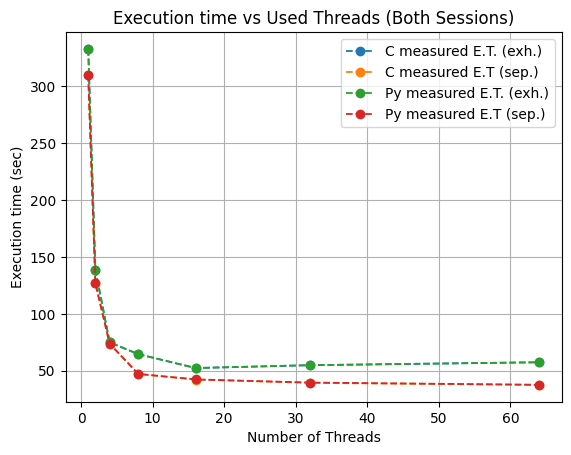

>Parallel speedup analysis:

FITTING RESULTS FOR THE PARALLEL SPEEDUP

C measured Speedup analysis (Exhaust Session):
--------------------------------
Amdahl's law fit p: 0.867
Parallel portion: 86.663 %
Maximum possible speedup at 10000 cores is S_latency(10000): 7.493219
--------------------------------

C measured Speedup analysis (Seperate Session):
--------------------------------
Amdahl's law fit p: 0.904
Parallel portion: 90.373 %
Maximum possible speedup at 10000 cores is S_latency(10000): 10.377693
--------------------------------

Python measured Speedup analysis (Exhaust Session):
--------------------------------
Amdahl's law fit p: 0.867
Parallel portion: 86.655 %
Maximum possible speedup at 10000 cores is S_latency(10000): 7.488809
--------------------------------

Python measured Speedup analysis (Seperate Session):
--------------------------------
Amdahl's law fit p: 0.903
Parallel portion: 90.330 %
Maximum possible speedup at 10000 cores is S_latency(10000): 10.332093
-

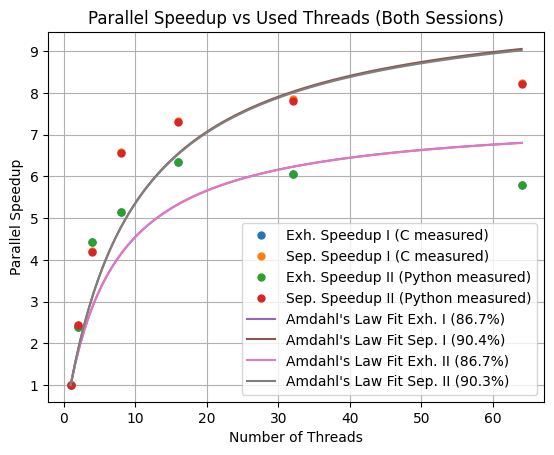

In [79]:
print("COMPARISON OF THE EXHAUST VS SEPERATE SESSION\n")

# Execution time analysis

# Printing and plotting the results for the execution time
exe_time_analysis_2(MC_exhaust_num_threads,MC_exhaust_times_C,MC_sep_times_C,MC_exhaust_times_Py,MC_sep_times_Py)

# Adding labels, title and legend to the plot for clarity
plt.xlabel("Number of Threads")
plt.ylabel("Execution time (sec)")
plt.title("Execution time vs Used Threads (Both Sessions)")
plt.legend()
plt.show()

# Parallel speedup analysis

# Presenting the parallel speedup results and the parallel speedup plot
par_speed_analysis_2(MC_exhaust_num_threads,MC_exhaust_times_C,MC_sep_times_C,MC_exhaust_times_Py,MC_sep_times_Py)

# Adding labels, title and legend to the plot for clarity
plt.xlabel("Number of Threads")
plt.ylabel("Parallel Speedup")
plt.title("Parallel Speedup vs Used Threads (Both Sessions)")
plt.legend()
plt.show()

### **4.2 Presenting the execution time and parallel speedup results from live Monte Carlo simulation session**

>Successful compilation!

>Running the .exe file!



>MONTE CARLO SIMULATION 1 running.....

>>MC SIMULATION INFO (C script):
--------------------------------------
Max Physical Threads: 22
Used Threads: 1
Total points: 1000000000
--------------------------------------
Pi Estimation: 3.1413910360
True Percent Relative Error: 0.006418%
Execution Time: 28.7290000000 seconds
--------------------------------------

>>MC SIMULATION INFO (Jupyter notebook)
--------------------------------------
Execution time: 28.8521289825 seconds
--------------------------------------


>MONTE CARLO SIMULATION 2 running.....

>>MC SIMULATION INFO (C script):
--------------------------------------
Max Physical Threads: 22
Used Threads: 2
Total points: 1000000000
--------------------------------------
Pi Estimation: 3.1414134360
True Percent Relative Error: 0.005705%
Execution Time: 13.5200000000 seconds
--------------------------------------

>>MC SIMULATION INFO (Jupyter notebook)
-------------------------

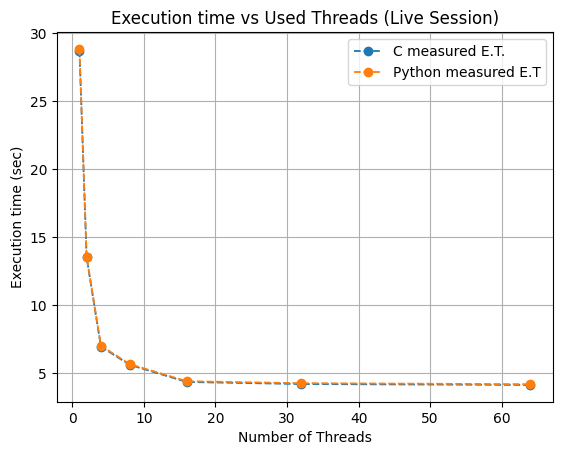

>Parallel speedup analysis:

FITTING RESULTS FOR THE PARALLEL SPEEDUP

C measured Speedup analysis:
--------------------------------
Amdahl's law fit p: 0.883
Parallel portion: 88.322 %
Maximum possible speedup at 10000 cores is S_latency(10000): 8.556428
--------------------------------

Python measured Speedup analysis:
--------------------------------
Amdahl's law fit p: 0.882
Parallel portion: 88.194 %
Maximum possible speedup at 10000 cores is S_latency(10000): 8.464254
--------------------------------



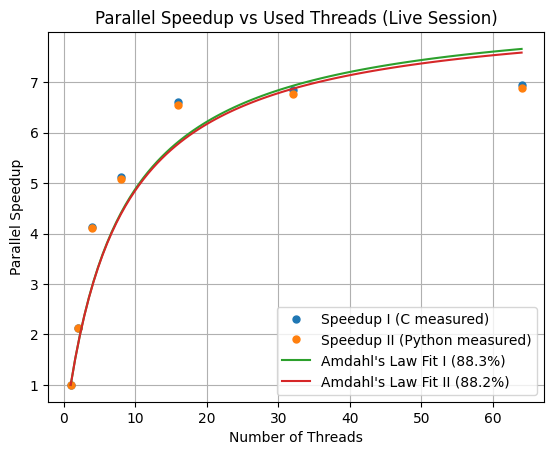

In [80]:
# Select a list containing different number of threads

# In my case i have an Intel Core Ultra 9 185H processor with
# 6 performance cores (i.e. 2 threads per core) and
# 10 efficient cores (i.e. 1 thread per core ) resulting
# in a total of 22 physical threads, so i chose the values
# [1,2,4,8,16,32,64] for the used threads

# As for the points i chose 10^9 total random points to be generated 
# in order to get a short-timed Monte Carlo Parallel Session

# Of course the afformentioned choices can be changed depending on the hardware and its potential
# of one's PC, in order to get a short-timed Monte Carlo Parallel Session

# Defining the number of threads list
num_threads = [1,2,4,8,16,32,64]

# Notice that if want to give ONLY ONE number of threads
# you have to declare also as a list, for the algorithm
# reads only iterable objects in the 'for' loop. For example
# if you want only 8 threads to be used you need to insert them as
# [8] in the "pi_estimation_parallel_1()" function

# Defining the total random points to be generated
points = 10**9

# Running the "pi_estimation_parallel_1()" function for the selected 
# number of threads and points and get the results
[pi_est_vals,MC_times_C_live,MC_times_Py_live] = pi_estimation_parallel_1(num_threads,points)

# Presenting the results
print("LIVE SESSION RESULTS\n")

# Execution time analysis

# Presenting the execution difference results and the execution plot
exe_time_analysis_1(num_threads,MC_times_C_live,MC_times_Py_live)

# Adding labels, title and legend to the plot for clarity
plt.xlabel("Number of Threads")
plt.ylabel("Execution time (sec)")
plt.title("Execution time vs Used Threads (Live Session)")
plt.legend()
plt.show()

# Parallel speedup analysis

# Presenting the speedup results and the speedup plot
par_speed_analysis_1(num_threads,MC_times_C_live,MC_times_Py_live)

# Adding labels, title and legend to the plot for clarity
plt.xlabel("Number of Threads")
plt.ylabel("Parallel Speedup")
plt.title("Parallel Speedup vs Used Threads (Live Session)")
plt.legend()
plt.show()
